# Classificazione della qualità dei vini
Per la classificazione delle diverse tipologie di vino abbiamo effettuato un confronto tra i diversi modelli di _apprendimento supervisionato_ con l'obiettivo di trovare il classificatore migliore in grado di determinare il valore più attendibile per il confronto della qualità

Importiamo i moduli e le librerie utili alla realizzazione del sistema

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import GridSearchCV, KFold, train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, matthews_corrcoef
from imblearn.over_sampling import SMOTE
from sklearn.metrics import ConfusionMatrixDisplay 
from imblearn.metrics import geometric_mean_score

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

## Load del dataset
Carichiamo il dataset in locale e lo visualizziamo

In [2]:
df = pd.read_csv("../Dataset/wine_quality.csv")

df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


# Pulizia dei dati
## Controllo e pulizia dei valori nulli
Controlliamo la possibile presenza di valori nulli ed eventualmente eliminarli

In [3]:
print(df.isnull().sum())

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64


<Axes: >

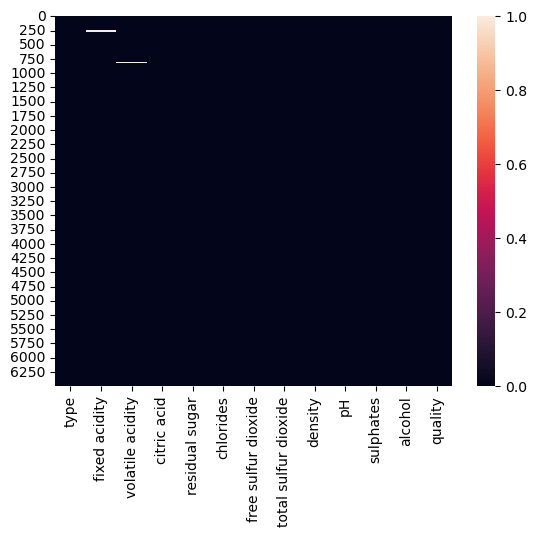

In [4]:
sns.heatmap(df.isnull())

Per ogni colonnna, invece di eliminare le righe con i valori nulli, rimpiazziamo il valore associato con la media o mediana. 
La semplice eliminazione delle righe ridurrà considerevolmente la dimensione del set di dati, ma potrebbe ridurre le prestazioni dei modelli di apprendimento.

In [5]:
#Rimpiazzo i valori nulli in fixed acidity con la mediana
df['fixed acidity'].fillna(df['fixed acidity'].median(), inplace=True)
df['fixed acidity'].isna().sum()

0

In [6]:
#Rimpiazzo i valori nulli in volatile acidity con la media
df['volatile acidity'].fillna(df['volatile acidity'].mean(), inplace=True)
df['volatile acidity'].isna().sum()

0

In [7]:
#Rimpiazzo i valori nulli in citric acid con la media
df['citric acid'].fillna(df['citric acid'].mean(), inplace=True)
df['citric acid'].isna().sum()

0

In [8]:
#Rimpiazzo i valori nulli in residual sugar con la media
df['residual sugar'].fillna(df['residual sugar'].mean(), inplace=True)
df['residual sugar'].isna().sum()

0

In [9]:
#Rimpiazzo i valori nulli in chlorides con la mediana
df['chlorides'].fillna(df['chlorides'].median(), inplace=True)
df['chlorides'].isna().sum()

0

In [10]:
#Rimpiazzo i valori nulli in pH con la media
df['pH'].fillna(df['pH'].mean(), inplace=True)
df['pH'].isna().sum()

0

In [11]:
#Rimpiazzo i valori nulli in sulphates con la mediana
df['sulphates'].fillna(df['sulphates'].median(), inplace=True)
df['sulphates'].isna().sum()

0

### Rimozione valori anomali

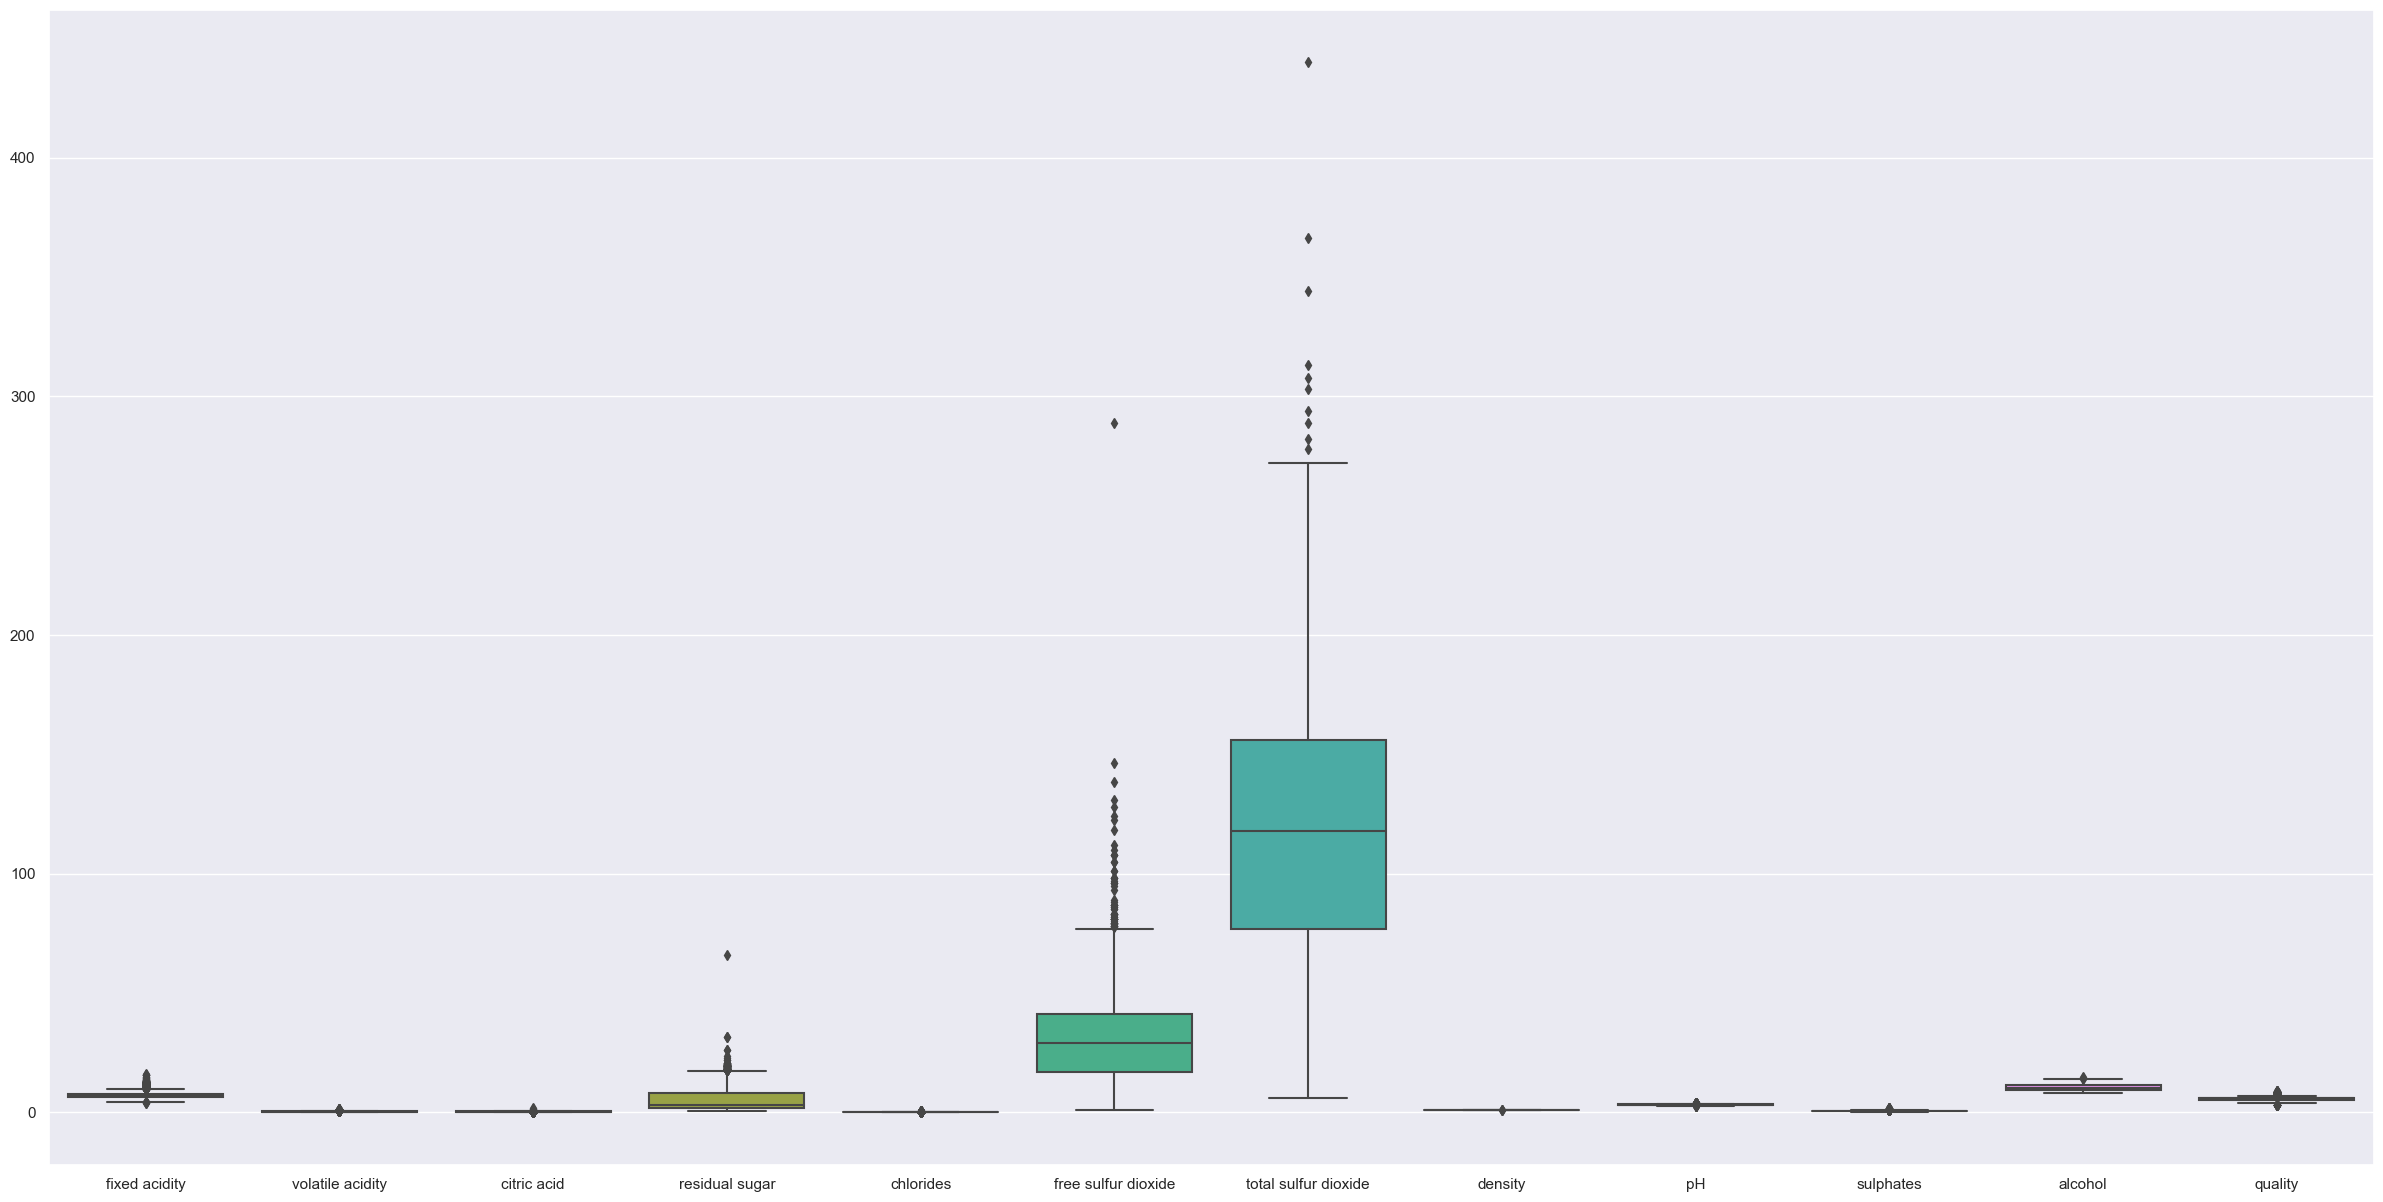

In [12]:
sns.set()
plt.figure(figsize=(30,15))
sns.boxplot(data=df)
plt.show()

Come possiamo vedere in residual sugar, free sulfur dioxide e total sulfur dioxide sono presenti valori anomali

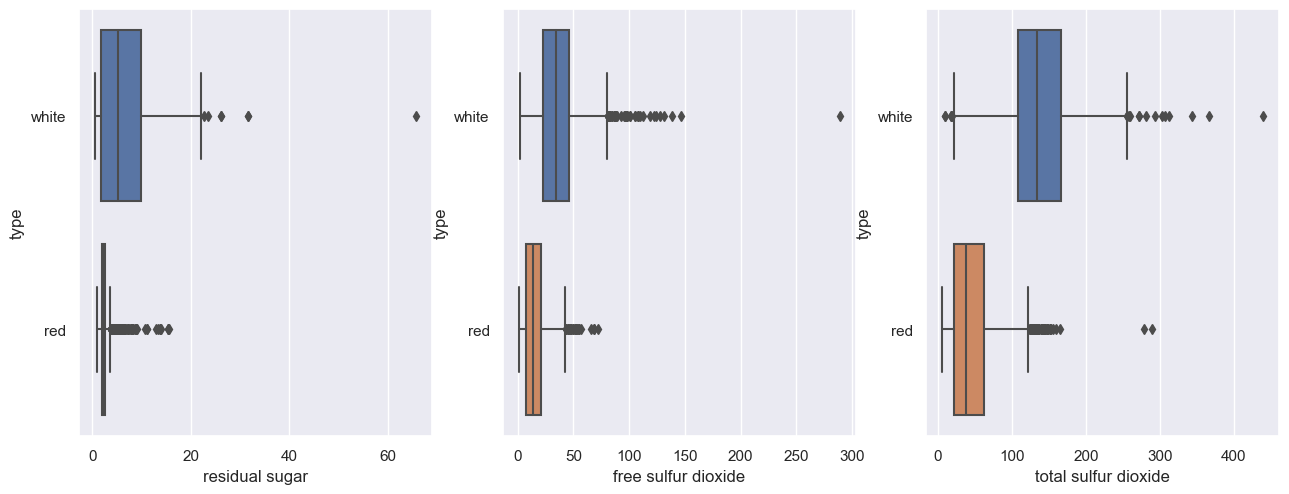

In [13]:
fig, ax =plt.subplots(1,3)
plt.subplots_adjust(right=2, top=1)
sns.boxplot(x=df['residual sugar'], y=df['type'], ax=ax[0])
sns.boxplot(x=df['free sulfur dioxide'], y=df['type'], ax=ax[1])
sns.boxplot(x=df['total sulfur dioxide'], y=df['type'], ax=ax[2])
plt.show()

Rimuoviamo eventuali valori anomali all'interno delle feature residual sugar, free sulfur dioxide, total sulfur dioxide

In [14]:
#Rimozione valori anomali in residual sugar
lower = df['residual sugar'].mean()-3*df['residual sugar'].std()
upper = df['residual sugar'].mean()+3*df['residual sugar'].std()
df = df[(df['residual sugar']>lower) & (df['residual sugar']<upper)]

#Rimozione valori anomali in free sulfur dioxide
lower = df['free sulfur dioxide'].mean()-3*df['free sulfur dioxide'].std()
upper = df['free sulfur dioxide'].mean()+3*df['free sulfur dioxide'].std()
df = df[(df['free sulfur dioxide']>lower) & (df['free sulfur dioxide']<upper)]

#Rimozione valori anomali in total sulfur dioxide
lower = df['total sulfur dioxide'].mean()-3*df['total sulfur dioxide'].std()
upper = df['total sulfur dioxide'].mean()+3*df['total sulfur dioxide'].std()
df = df[(df['total sulfur dioxide']>lower) & (df['total sulfur dioxide']<upper)]

<Axes: >

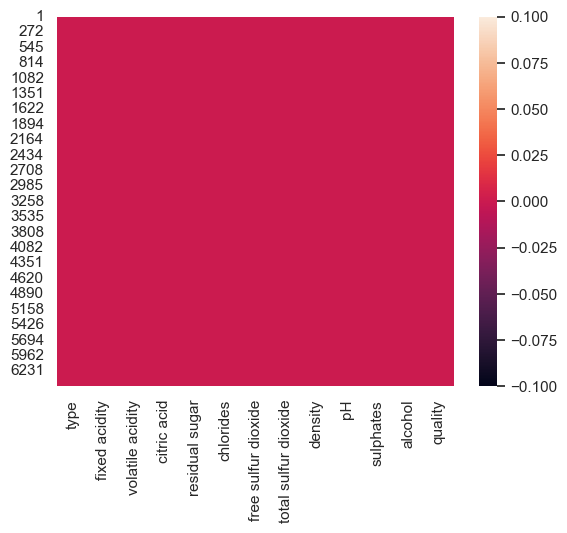

In [15]:
# heatmap per valori nulli
sns.heatmap(df.isnull())

In [16]:
print('Dimensione del dataset processato: ', df.shape)

Dimensione del dataset processato:  (6430, 13)


### Rimozione delle tuple duplicate

In [17]:
df = df.drop_duplicates()
df.reset_index()
df.shape

(5278, 13)

Come possiamo notare sono state eliminate circa 1200 righe dal dataset

### Visualizzazione statistica delle feature

Raggruppiamo i vini per "type" e visualizziamo una statistica che ci indichi i valori minimi, massimi e medi di ogni feature. Questo ci servirà , successivamente , nella realizzazione delle regole all'interno della nostra KB

In [18]:
result = df.groupby('type').agg({'fixed acidity': ['mean', 'min', 'max'],'volatile acidity': ['mean', 'min', 'max'],
                                'citric acid': ['mean', 'min', 'max'],'residual sugar': ['mean', 'min', 'max'],
                                'chlorides': ['mean', 'min', 'max'],'free sulfur dioxide': ['mean', 'min', 'max'],
                                'total sulfur dioxide': ['mean', 'min', 'max'],'density': ['mean', 'min', 'max'],
                                'pH': ['mean', 'min', 'max'],'sulphates': ['mean', 'min', 'max'],
                                'alcohol': ['mean', 'min', 'max']})

result = result.transpose()
#result.plot(kind='barh', title='Count (quality_label)')
result.head(33)

type                              red       white
fixed acidity        mean    8.311856    6.840855
                     min     4.600000    3.800000
                     max    15.900000   14.200000
volatile acidity     mean    0.529411    0.280675
                     min     0.120000    0.080000
                     max     1.580000    1.100000
citric acid          mean    0.272267    0.334405
                     min     0.000000    0.000000
                     max     1.000000    1.660000
residual sugar       mean    2.519146    5.831974
                     min     0.900000    0.600000
                     max    15.500000   19.600000
chlorides            mean    0.088152    0.045861
                     min     0.012000    0.009000
                     max     0.611000    0.346000
free sulfur dioxide  mean   15.877393   34.329464
                     min     1.000000    2.000000
                     max    72.000000   83.000000
total sulfur dioxide mean   46.647644  136.412245
                     min     6.000000    9.000000
                     max   278.000000  282.000000
density              mean    0.996712    0.993746
                     min     0.990070    0.987110
                     max     1.003690    1.001820
pH                   mean    3.309578    3.195681
                     min     2.740000    2.720000
                     max     4.010000    3.820000
sulphates            mean    0.658513    0.490186
                     min     0.330000    0.220000
                     max     2.000000    1.080000
alcohol              mean   10.430940   10.594068
                     min     8.400000    8.000000
                     max    14.900000   14.200000

## Bilanciamento classe quality prima della normalizzazione

<Axes: title={'center': 'Count (quality)'}>

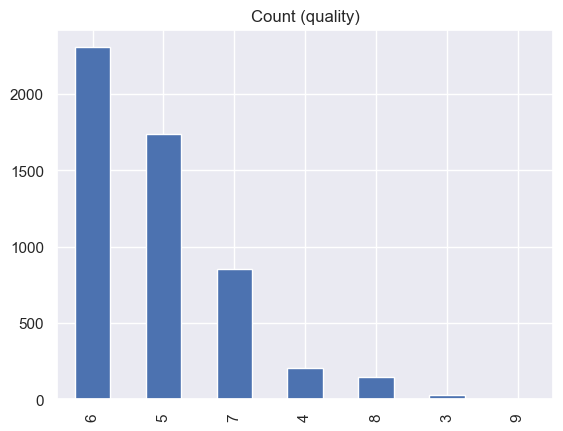

In [19]:
quality_count = df['quality'].value_counts()
quality_count.plot(kind='bar', title='Count (quality)')

## Normalizzazione delle feature numeriche e categoriche


### 1-Hot Encoder

La colonna 'type' , essendo feature categorica, deve essere trasformata in feature numerica attraverso il "1-hot encoding". Verrà, quindi, trasformata in una colonna a rappresentazione binaria. Usiamo, cioè, la funzione get_dummies() di Pandas per rimuovere la prima feature e trasformarla essenzialmente in una colonna di 1 e 0 dove 1 denota vino bianco e 0 denota vino rosso.

In [20]:
dummies = pd.get_dummies(df["type"], drop_first=True)
df = pd.concat([df, dummies], axis=1)
df.drop("type", axis=1, inplace=True)

Tracciamo una Heatmap per rappresentare la correlazione tra le features prese in considerazione

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,white
fixed acidity,1.000000,0.213678,0.330001,-0.110387,0.289393,-0.292401,-0.333708,0.492625,-0.269848,0.308504,-0.104582,-0.079849,-0.486987
volatile acidity,0.213678,1.000000,-0.388757,-0.178600,0.367529,-0.360992,-0.405826,0.308677,0.246452,0.227162,-0.068169,-0.266994,-0.645933
citric acid,0.330001,-0.388757,1.000000,0.143484,0.056008,0.148696,0.196010,0.092481,-0.344871,0.061183,-0.010639,0.098193,0.185370
residual sugar,-0.110387,-0.178600,0.143484,1.000000,-0.129263,0.439823,0.502877,0.489904,-0.234278,-0.175557,-0.314914,-0.056616,0.335164
chlorides,0.289393,0.367529,0.056008,-0.129263,1.000000,-0.192930,-0.272484,0.383151,0.026001,0.406638,-0.271485,-0.204264,-0.500057
free sulfur dioxide,-0.292401,-0.360992,0.148696,0.439823,-0.192930,1.000000,0.728142,0.008792,-0.153498,-0.214149,-0.175300,0.082814,0.485239
total sulfur dioxide,-0.333708,-0.405826,0.196010,0.502877,-0.272484,0.728142,1.000000,-0.002841,-0.224104,-0.280617,-0.251082,-0.038090,0.701344
density,0.492625,0.308677,0.092481,0.489904,0.383151,0.008792,-0.002841,1.000000,0.040013,0.296488,-0.687309,-0.336858,-0.449891
pH,-0.269848,0.246452,-0.344871,-0.234278,0.026001,-0.153498,-0.224104,0.040013,1.000000,0.163099,0.096015,0.039954,-0.311429
sulphates,0.308504,0.227162,0.061183,-0.175557,0.406638,-0.214149,-0.280617,0.296488,0.163099,1.000000,-0.021555,0.038303,-0.491477


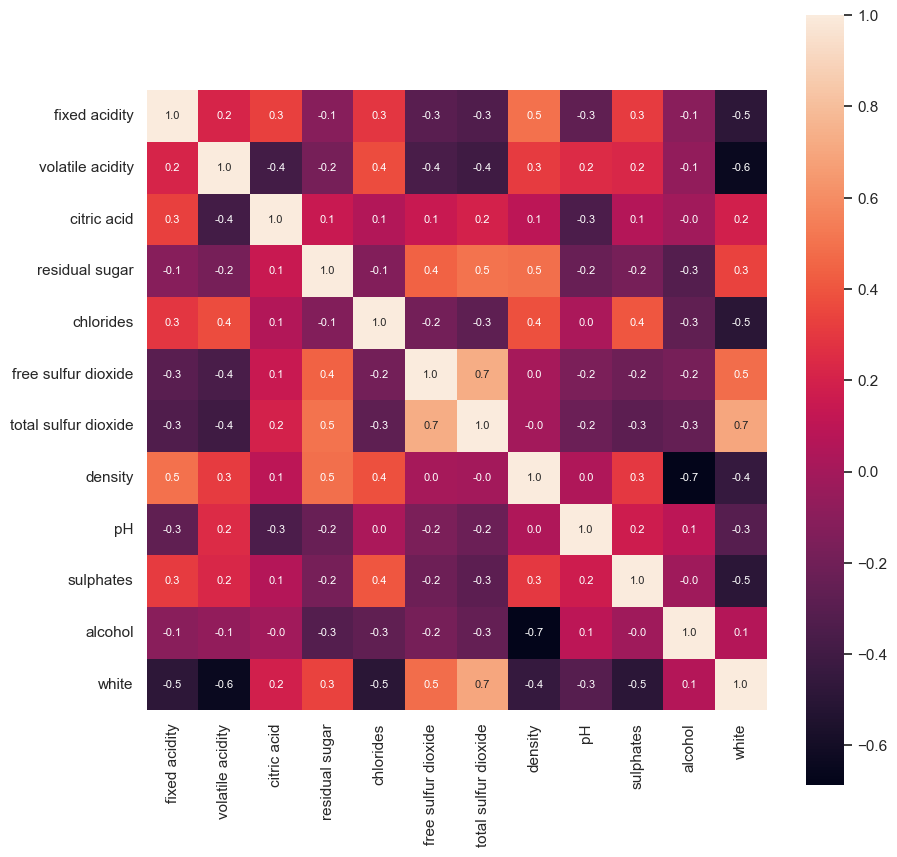

In [21]:
#Controlliamo la correlazione tra le varie feature
cor=df.corr()
features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol','white']
plt.figure(figsize=(10,10))
sns.heatmap(df[features].corr(), cbar=True, square=True, fmt = '.1f', annot = True, annot_kws={'size':8})
cor

Come possiamo notare 'density' ha una correlazione negativa leggermente forte con l'alcol. Perciò, questa feature non verrà considerata nella fase di 'costruzione dei modelli e addestramento'.

### Quality Label
Creiamo la quality label basata sulla già esistente colonna 'quality'

- bad per un punteggio minore o uguale di 5
- good per più di 5

In [22]:
df['quality_label'] = df.quality.apply(lambda q: 'bad' if q <= 6 else 'good')

### Distribuzione della classe quality

Osserviamo la correlazione tra la qualità del vino e la percentuale alcolica

<Axes: xlabel='quality', ylabel='alcohol'>

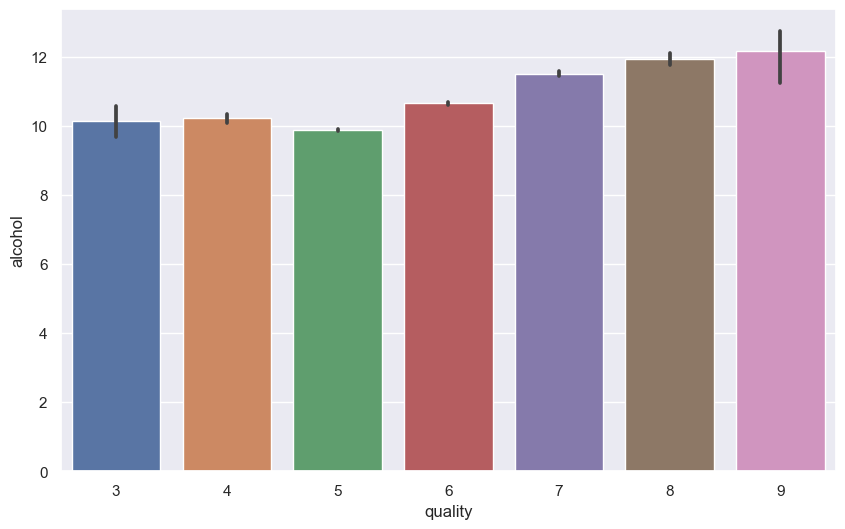

In [23]:
fig = plt.figure(figsize = (10,6))
sns.barplot(x = 'quality', y = 'alcohol', data = df)

Come possiamo notare la qualità di un vino cresce all'aumentare del grado alcolico.

Osserviamo ora il bilanciamento della classe quality_label, cioè il target della classificazione:

<Axes: title={'center': 'Count (quality_label)'}>

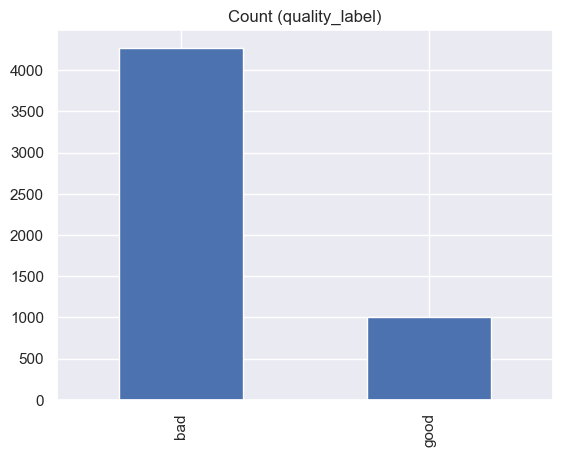

In [24]:
quality_count = df['quality_label'].value_counts()
quality_count.plot(kind='bar', title='Count (quality_label)')

In [25]:
df.quality_label.value_counts()

bad     4273
good    1005
Name: quality_label, dtype: int64

Come possiamo notare il nostro dataset è molto sbilanciato. Abbiamo 4273 vini classificati come qualità "bad" e 1005 "good".

### Distribuzione della classe type

<Axes: title={'center': 'Count (type)'}>

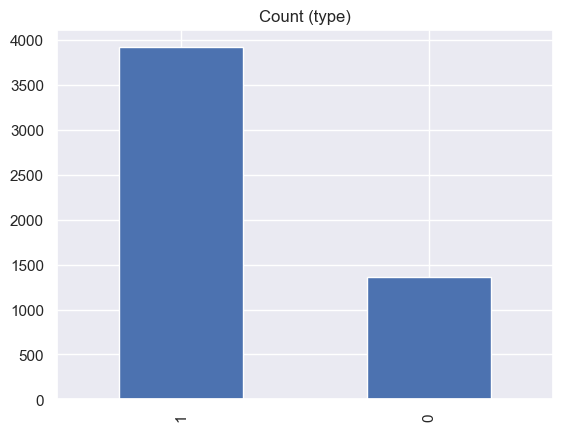

In [26]:
type_count = df['white'].value_counts()
type_count.plot(kind='bar', title='Count (type)')

Inoltre, possiamo notare che all'interno del nostro dataset ci sono più vini bianchi che rossi

C:\Users\miche\AppData\Local\Temp\ipykernel_18504\3438276181.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<Axes: >

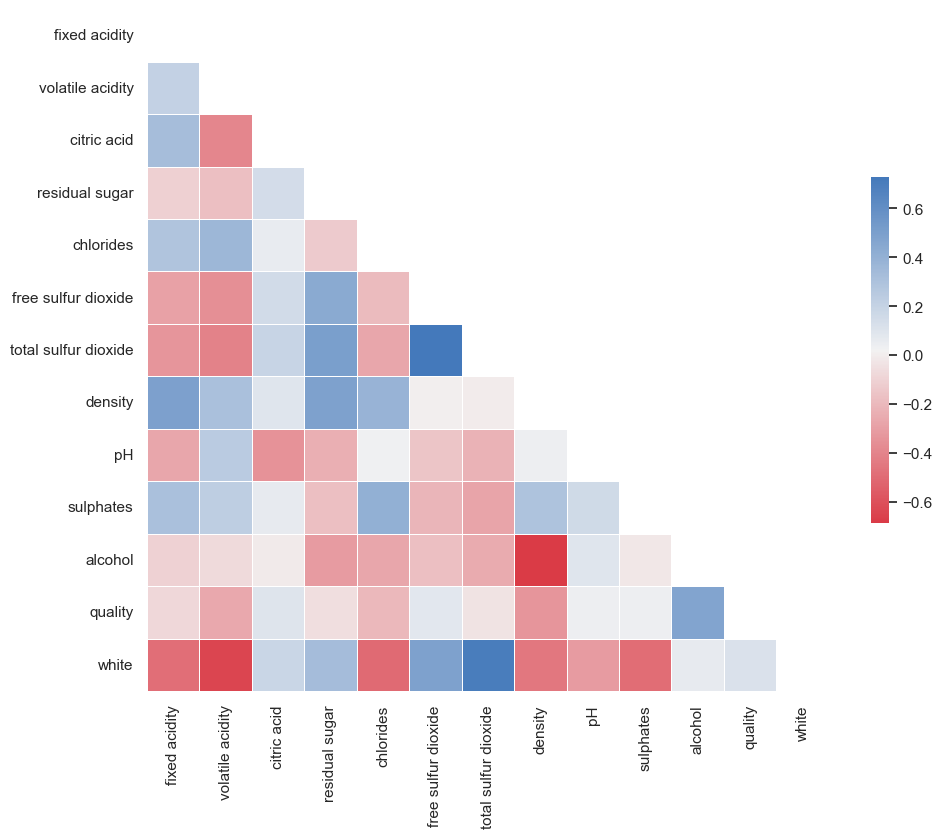

In [27]:
# chiamo .corr() per calcolare la correlazione a coppie tra le feature del dataframe
corr = df.corr()

# visualizzazione dei dati
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.set_style(style = 'white')
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, 
        square=True,
        linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

Da questa heatmap si evince che total sulfur dioxide e free sulfur dioxide sonno correlati maggiormente con i vini bianchi e viceversa.

Utilizziamo la classe LabelEncoder per poter convertire la colonna  'quality_label' in feature numerica

In [28]:
ord_enc = OrdinalEncoder()
df["quality_label"] = ord_enc.fit_transform(df[["quality_label"]]) # assume 1 se good 0 se bad
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,white,quality_label
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,1,0.0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,1,0.0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1,0.0
6,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,6,1,0.0
9,8.1,0.22,0.43,1.5,0.044,28.0,129.0,0.9938,3.22,0.45,11.0,6,1,0.0


# Costruzione dei modelli & Addestramento
## Preparazione del dataset
Prenderemo come target la colonna 'quality_label' per una maggiore accuratezza. Avendo già convertito questo attributo categorico utilizzando la classe LabelEncoder, possiamo procedere alla costruzione dei vari modelli di classificazione ed addestramento.

In [29]:
print(df['quality_label'].value_counts())

0.0    4273
1.0    1005
Name: quality_label, dtype: int64


## Divisione del dataset

Dividiamo ora il dataset in train e test considerando soltanto le feature che hanno più importanza, infatti la densità non verrà considerata per questo esperimento. Così facendo viene ridotta la complessità dei vari modelli.

In [30]:
X = df.drop(['quality_label','quality','density'], axis = 1)
y = df['quality_label']

### Applicazione di SMOTE per il bilanciamento dei dati

SMOTE (synthetic minority oversampling technique) è una tecnica di oversampling sul set di training, utile a risolvere il problema dello sbilanciamento dei dati. Nel nostro dataset, come abbiamo visto precedentemente, ci sono più istanze di vini bianchi e meno istanze di vini rossi, quindi i dati devono essere bilanciati per poter rimuovere il "bias". Inoltre, sono stati trovati più vini nel range di 'quality' che va da 3 a 9, mentre nessun vino è stato trovato oltre questo range. Ossia, ci sono molti più vini 'bad' che 'good'.

In [31]:
# Applicazione di SMOTE per bilanciare le classi
oversample = SMOTE()
X1, y1 = oversample.fit_resample (X, y)

<Axes: title={'center': 'Count (quality_label)'}>

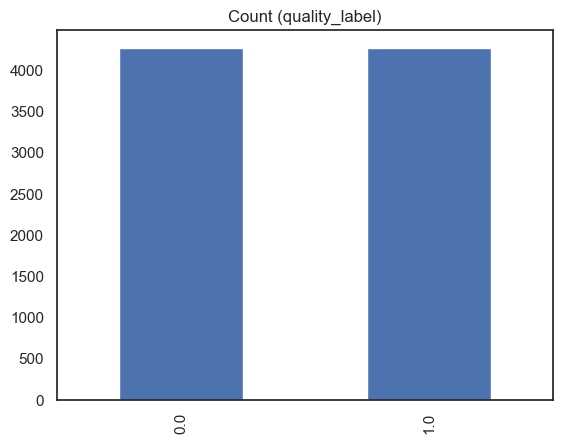

In [32]:
quality_count = y1.value_counts()
quality_count.plot(kind='bar', title='Count (quality_label)')

Colonna quality dopo l'applicazione di SMOTE

Come possiamo notare , adesso, dopo l'applicazione della tecnica SMOTE, il nostro dataset è completamente bilanciato, quindi è possibile procedere con gli algoritmi di Classificazione. 

### Train e test set

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size = 0.2,random_state = 11)

# Naive Bayes
Tramite questo classificatore possiamo calcolare la probabilità che un determinato evento avvenga all'interno del dataset.

La costruzione del classificatore avviene nel seguente modo: si crea un oggetto della classe GaussianNB e successivamente viene chiamato il metodo fit, specificando come argomenti le osservazioni e le corrispondenti etichette. Infine invochiamo il metodo predict passando come argomento una lista di oggetti da classificare.

In [34]:
clf = GaussianNB()

Istanziamo un oggetto della classe StratifiedKFold che ci permetterà di andare a definire un tipo di Cross Validation

In [35]:
stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=5)

### Hyperparameter tuning e Ricerca dei parametri migliori

GuassianNB non accetta nessun parametro, infatti:
 - lanciando il comando GaussianNB().get_params().keys() avremmo come risultato un dizionario vuoto

In [36]:
# in param_grid sono definiti gli iperparametri
param_grid = {}

grid_search = GridSearchCV(estimator=clf,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=stratified_kfold,
                           verbose = 1,
                           n_jobs=-1) # utilizzerà tutti i processori disponibili
# fase di training del modello
grid_search.fit(X_train, y_train.values.ravel())

cv_score = grid_search.best_score_

# effetuamo la predizione sul set di test
y_test_predict = grid_search.predict(X_test)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


Le metriche che considereremo per ogni modello saranno:

- accuracy
- recall
- precision
- f1
- matthews correlation coefficent
- geometric mean score

accuracy: 0.7087719298245614
precision: 0.7198418509720717
recall: 0.7086402088029942
f1: 0.7049746679674508
matthews_corrcoef: 0.42833561463156317
geometric_mean_score: 0.7086402088029942


[]

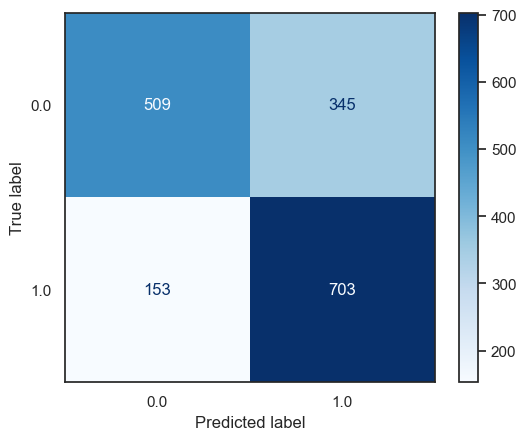

In [37]:
# calcoliamo le metriche di valutazione
accuracy = accuracy_score(y_test, y_test_predict)
precision = precision_score(y_test, y_test_predict, average='macro')
recall = recall_score(y_test, y_test_predict, average='macro')
f1 = f1_score(y_test, y_test_predict, average='macro')
mcc = matthews_corrcoef(y_test, y_test_predict)
gm = geometric_mean_score(y_test, y_test_predict, average='macro')
ConfusionMatrixDisplay.from_predictions(y_test, 
                                        y_test_predict, 
                                        cmap=plt.cm.Blues)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')
print(f'matthews_corrcoef: {mcc}')
print(f'geometric_mean_score: {gm}')

plt.plot()

In [38]:
scoring_list = []
scoring_list.append(dict([
    ('Model', 'Naive Bayes'),
    ('Train Accuracy', round(cv_score, 3)),
    ('Test Accuracy', round(accuracy, 3)),
    ('Precision', round(precision, 3)),
    ('Recall', round(recall, 3)),
    ('F1', round(f1, 3)),
    ('Matthews Corrcoef', round(mcc,3)),
    ('Geometric Mean Score', round(gm, 3))
     ]))

# Random Forest
Useremo il Random Forest della libreria scikit-learn, che calcola la media della previsione probabilistica di tutti gli alberi nella foresta per la previsione finale invece di prendere i voti di previsione effettivi e quindi calcolarne la media

In [39]:
clf = RandomForestClassifier(max_depth=12, random_state=5)

In [40]:
stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)

### Hyperparameter Tuning

In [41]:
# in param_grid sono definiti gli iperparametri
param_grid = {
                'n_estimators': [50,100, 200],
                'max_depth': [6,10, 12],
                'random_state': [0,4,5,11,101]
                }

grid_search = GridSearchCV(estimator=clf,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=stratified_kfold,
                           verbose = 5,
                           n_jobs=-1) # utilizzerà tutti i processori disponibili

### Ricerca dei parametri migliori

In [42]:
# troviamo il modello migliore
grid_search.fit(X_train, y_train.values.ravel())

cv_score = grid_search.best_score_
best_params = grid_search.best_params_

print(f'Best parameters: {best_params}')
print(f'Cross-validation score: {cv_score}')

# effetuamo la predizione sul set di test
y_test_predict = grid_search.predict(X_test)

Fitting 3 folds for each of 45 candidates, totalling 135 fits
Best parameters: {'max_depth': 12, 'n_estimators': 200, 'random_state': 0}
Cross-validation score: 0.8556169928562284


accuracy: 0.8660818713450292
precision: 0.870495812038123
recall: 0.8660180787498085
f1: 0.8656672641355712
matthews_corrcoef: 0.7365002791772558
geometric_mean_score: 0.8660180787498085


[]

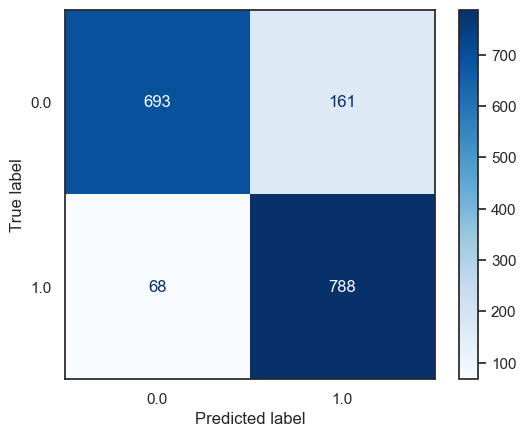

In [43]:
# calcoliamo le metriche di valutazione
accuracy = accuracy_score(y_test, y_test_predict)
precision = precision_score(y_test, y_test_predict, average='macro')
recall = recall_score(y_test, y_test_predict, average='macro')
f1 = f1_score(y_test, y_test_predict, average='macro')
mcc = matthews_corrcoef(y_test, y_test_predict)
gm = geometric_mean_score(y_test, y_test_predict, average='macro')
ConfusionMatrixDisplay.from_predictions(y_test, 
                                        y_test_predict, 
                                        cmap=plt.cm.Blues)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')
print(f'matthews_corrcoef: {mcc}')
print(f'geometric_mean_score: {gm}')

plt.plot()

In [44]:
scoring_list.append(dict([
    ('Model', 'RandomForest'),
    ('Train Accuracy', round(cv_score, 3)),
    ('Test Accuracy', round(accuracy, 3)),
    ('Precision', round(precision, 3)),
    ('Recall', round(recall, 3)),
    ('F1', round(f1, 3)),
    ('Matthews Corrcoef', round(mcc,3)),
    ('Geometric Mean Score', round(gm, 3))
     ]))

# KNN

l KNN è un algoritmo di classificazione che mira a determinare la classe di appartenenza di un dato di input
cercando tra tutti gli esempi di addestramento quello più vicino al dato di input in base alla metrica
desiderata, come ad esempio la distanza euclidea

In [45]:
clf = KNeighborsClassifier()

In [46]:
stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)

### Hyperparameter tuning

In [47]:
# in param_grid sono definiti gli iperparametri
param_grid = {
         'n_neighbors': [10, 11, 12, 13] ,
         'weights': ['distance'],
         'algorithm' : ['ball_tree', 'kd_tree' ],
         'leaf_size': [12, 11, 13],
         'p': [1,2]
}


grid_search = GridSearchCV(estimator=clf,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=stratified_kfold,
                           verbose = 5,
                           n_jobs=-1) # utilizzerà tutti i processori disponibili

### Ricerca dei parametri migliori

In [48]:
# troviamo il modello migliore
grid_search.fit(X_train, y_train.values.ravel())

cv_score = grid_search.best_score_
best_params = grid_search.best_params_

print(f'Best parameters: {best_params}')
print(f'Cross-validation score: {cv_score}')

# effetuamo la predizione sul set di test
y_test_predict = grid_search.predict(X_test)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best parameters: {'algorithm': 'ball_tree', 'leaf_size': 12, 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
Cross-validation score: 0.8060270364359191


accuracy: 0.8321637426900584
precision: 0.8603964806771356
recall: 0.8320000437742125
f1: 0.8287624750568645
matthews_corrcoef: 0.6918139847123103
geometric_mean_score: 0.8320000437742125


[]

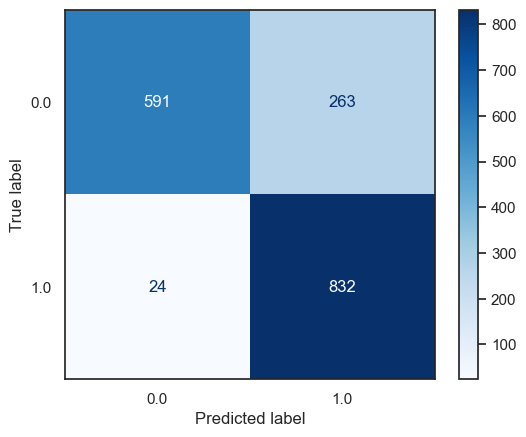

In [49]:
# calcoliamo le metriche di valutazione
accuracy = accuracy_score(y_test, y_test_predict)
precision = precision_score(y_test, y_test_predict, average='macro')
recall = recall_score(y_test, y_test_predict, average='macro')
f1 = f1_score(y_test, y_test_predict, average='macro')
mcc = matthews_corrcoef(y_test, y_test_predict)
gm = geometric_mean_score(y_test, y_test_predict, average='macro')
ConfusionMatrixDisplay.from_predictions(y_test, 
                                        y_test_predict, 
                                        cmap=plt.cm.Blues)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')
print(f'matthews_corrcoef: {mcc}')
print(f'geometric_mean_score: {gm}')

plt.plot()

In [50]:
scoring_list.append(dict([
    ('Model', 'KNN'),
    ('Train Accuracy', round(cv_score, 3)),
    ('Test Accuracy', round(accuracy, 3)),
    ('Precision', round(precision, 3)),
    ('Recall', round(recall, 3)),
    ('F1', round(f1, 3)),
    ('Matthews Corrcoef', round(mcc,3)),
    ('Geometric Mean Score', round(gm, 3))
     ]))

# Support Vector Machine

Il Support Vector Machine (SVM) è un modello di apprendimento supervisionato in grado di eseguire attività di classificazione e regressione. L'algoritmo SVM mira a creare la migliore linea o confine decisionale in grado di separare lo spazio n-dimensionale in classi. Questo miglior "limite decisionale"  è chiamato iperpiano.

In [51]:
clf = SVC(kernel=None,gamma=None,C=None)

stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)

### Hyperparameter tuning

In [52]:
# in param_grid sono definiti gli iperparametri
param_grid = {'C': [0.08, 0.1, 1, 10, 100], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf'] # linear
              }

grid_search = GridSearchCV(estimator=clf,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=stratified_kfold,
                           verbose = 5,
                           n_jobs=-1) # utilizzerà tutti i processori disponibili

### Ricerca dei parametri migliori

In [53]:
# troviamo il modello migliore
grid_search.fit(X_train, y_train.values.ravel())

cv_score = grid_search.best_score_
best_params = grid_search.best_params_

print(f'Best parameters: {best_params}')
print(f'Cross-validation score: {cv_score}')

# effetuamo la predizione sul set di test
y_test_predict = grid_search.predict(X_test)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Cross-validation score: 0.8638100954330636


accuracy: 0.8894736842105263
precision: 0.8972161172161173
recall: 0.8893921403401257
f1: 0.8889174929084753
matthews_corrcoef: 0.7865693461110167
geometric_mean_score: 0.8893921403401257


[]

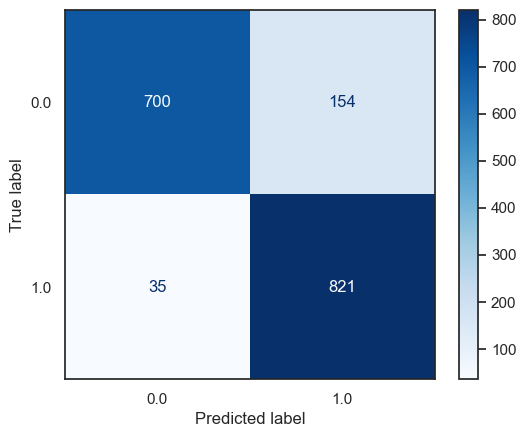

In [54]:
# calcoliamo le metriche di valutazione
accuracy = accuracy_score(y_test, y_test_predict)
precision = precision_score(y_test, y_test_predict, average='macro')
recall = recall_score(y_test, y_test_predict, average='macro')
f1 = f1_score(y_test, y_test_predict, average='macro')
mcc = matthews_corrcoef(y_test, y_test_predict)
gm = geometric_mean_score(y_test, y_test_predict, average='macro')
ConfusionMatrixDisplay.from_predictions(y_test, 
                                        y_test_predict, 
                                        cmap=plt.cm.Blues)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')
print(f'matthews_corrcoef: {mcc}')
print(f'geometric_mean_score: {gm}')

plt.plot()

In [55]:
scoring_list.append(dict([
    ('Model', 'SVM'),
    ('Train Accuracy', round(cv_score, 3)),
    ('Test Accuracy', round(accuracy, 3)),
    ('Precision', round(precision, 3)),
    ('Recall', round(recall, 3)),
    ('F1', round(f1, 3)),
    ('Matthews Corrcoef', round(mcc,3)),
    ('Geometric Mean Score', round(gm, 3))
     ]))

# Confronto dei vari modelli

In [56]:
results = pd.DataFrame(data=scoring_list)
results = results[['Model',
                   'Train Accuracy',
                   'Test Accuracy',
                   'Precision',
                   'Recall',
                   'F1',
                   'Matthews Corrcoef',
                   'Geometric Mean Score']]

results = results.sort_values(by='Recall', ascending=False)

print(results)

          Model  Train Accuracy  Test Accuracy  Precision  Recall     F1  \
3           SVM           0.864          0.889      0.897   0.889  0.889   
1  RandomForest           0.856          0.866      0.870   0.866  0.866   
2           KNN           0.806          0.832      0.860   0.832  0.829   
0   Naive Bayes           0.715          0.709      0.720   0.709  0.705   

   Matthews Corrcoef  Geometric Mean Score  
3              0.787                 0.889  
1              0.737                 0.866  
2              0.692                 0.832  
0              0.428                 0.709  


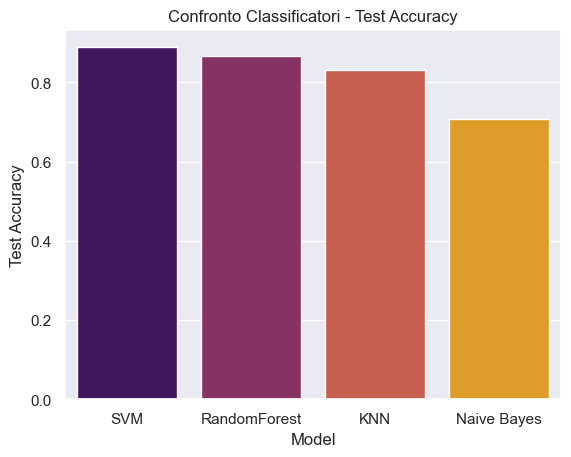

In [57]:
with sns.axes_style("darkgrid"):
    sns.barplot(data = results,
                x=results['Model'],
                y=results['Test Accuracy'],
                palette = 'inferno').set(title = "Confronto Classificatori - Test Accuracy")

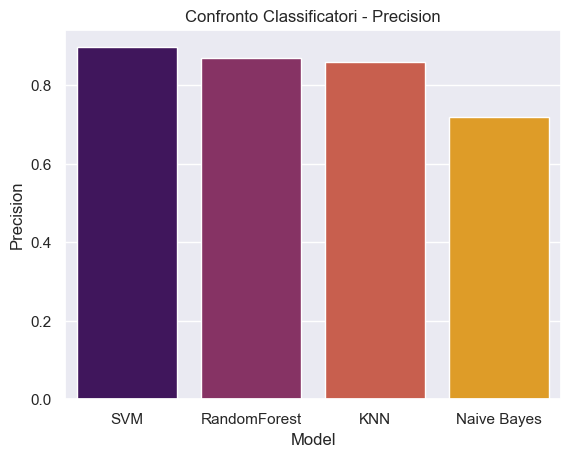

In [58]:
with sns.axes_style("darkgrid"):
    sns.barplot(data = results,
                x=results['Model'],
                y=results['Precision'],
                palette = 'inferno').set(title = "Confronto Classificatori - Precision")

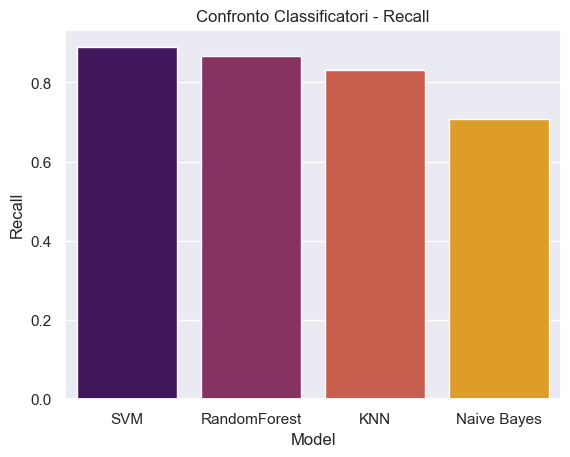

In [59]:
with sns.axes_style("darkgrid"):
    sns.barplot(data = results,
                x=results['Model'],
                y=results['Recall'],
                palette = 'inferno').set(title = "Confronto Classificatori - Recall")

Come possiamo vedere dai grafici precedenti, il modello migliore è risultato il Support Vector Machine (accuracy dell'88%) seguito dal Random Forest (accuracy dell' 87%) con indice di profondità pari a 12. Nel complesso quasi tutti i modelli si sono comportati circa in egual modo, a differenza del Naive Bayes che ha restiuito un Accuracy dell'70% circa